In [1]:
#importing packages
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.optimize as spop

In [2]:
# Specifying the sample
ticker = 'TSLA'
start = '2020-01-01'
end = '2024-01-01'

In [3]:
# Downloading data
prices = yf.download(ticker, start, end)['Close']
# Calculating returns
returns = np.array(prices)[1:] / np.array(prices)[:-1] - 1

[*********************100%***********************]  1 of 1 completed


In [4]:
# Set the model parameters
con = 0 # long-term mean return
w = 0.4 # omega
a = 0.2 # alpha
b = 0.5 # beta
sigma_0 = np.sqrt(w / (1 - a - b))

In [5]:
# Setting number of periods
n = 100 # 10^2

In [6]:
# Starting parameter values - sample mean and variance
mean = np.mean(returns)
var = np.var(returns)

In [7]:
params_initial = [mean, var, 0, 0]
mu = 0

In [8]:
def garch_mle(params, returns):
    mu, omega, alpha, beta = params
    long_run = omega / (1 - alpha - beta)
    resid = returns - mu
    conditional = np.zeros(len(returns))
    conditional[0] = long_run
    for t in range(1, len(returns)):
        conditional[t] = np.sqrt(omega + alpha * resid[t - 1]**2 + beta * conditional[t - 1]**2)
    likelihood = 1 / (np.sqrt(2 * np.pi * conditional)) * np.exp(-resid**2 / (2 * conditional))
    log_likelihood = np.sum(np.log(likelihood))
    return -log_likelihood

In [9]:
# Maximizing log-likelihood
res = spop.minimize(garch_mle, params_initial, args=(returns,), method='L-BFGS-B')

C:\Users\alrem\AppData\Local\Temp\ipykernel_3936\2915936203.py:8: RuntimeWarning: invalid value encountered in sqrt
  conditional[t] = np.sqrt(omega + alpha * resid[t - 1]**2 + beta * conditional[t - 1]**2)
C:\Users\alrem\AppData\Local\Temp\ipykernel_3936\2915936203.py:9: RuntimeWarning: invalid value encountered in sqrt
  likelihood = 1 / (np.sqrt(2 * np.pi * conditional)) * np.exp(-resid**2 / (2 * conditional))
C:\Users\alrem\AppData\Local\Temp\ipykernel_3936\2915936203.py:9: RuntimeWarning: overflow encountered in exp
  likelihood = 1 / (np.sqrt(2 * np.pi * conditional)) * np.exp(-resid**2 / (2 * conditional))


In [10]:
# Retrieving optimal parameters
mu, omega, alpha, beta = res.x
log_likelihood = -res.fun

In [11]:
# Printing optimal parameters
print('GARCH model parameters:')
print(f'mu: {mu:.6f}')
print(f'omega: {omega:.6f}')
print(f'alpha: {alpha:.4f}')
print(f'beta: {beta:.4f}')
print(f'log-likelihood: {log_likelihood:.4f}')

GARCH model parameters:
mu: 0.003070
omega: 0.001839
alpha: 0.0000
beta: 0.0000
log-likelihood: nan


In [12]:
conditional = np.zeros(len(returns))
conditional[0] = np.sqrt(omega / (1 - alpha - beta))
for t in range(1, len(returns)):
    conditional[t] = np.sqrt(omega + alpha * (returns[t-1] - mu)**2 + beta * conditional[t-1]**2)

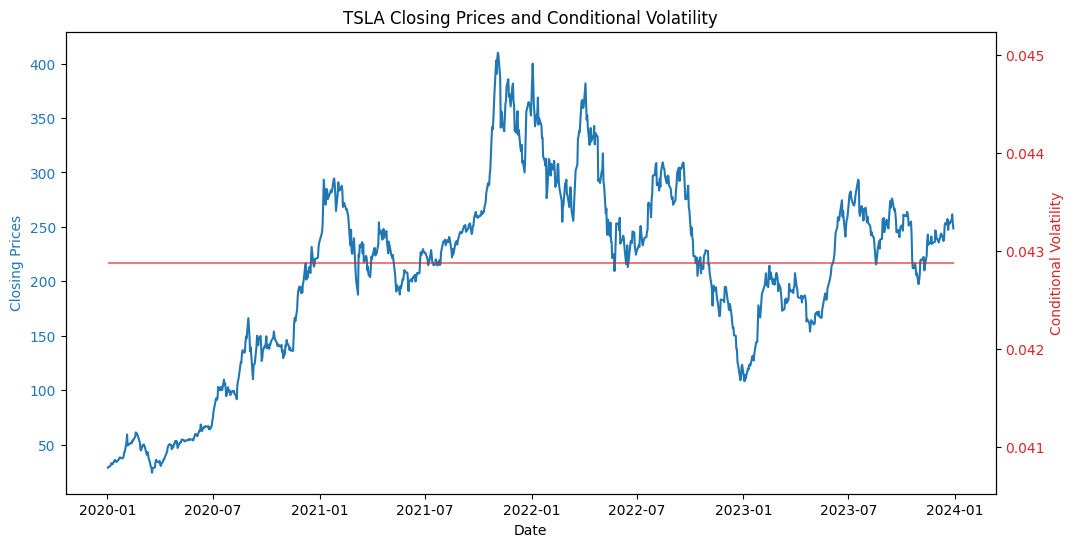

In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# Plotting closing prices and conditional volatility
fig, ax1 = plt.subplots(figsize=(12, 6))
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Closing Prices', color=color)
ax1.plot(prices.index, prices, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Conditional Volatility', color=color)
ax2.plot(prices.index[1:], conditional, color=color, alpha=0.6)
ax2.tick_params(axis='y', labelcolor=color)
plt.title('TSLA Closing Prices and Conditional Volatility')
plt.show()

In [14]:
# Assuming 252 trading days in a year
forecast_length = 252
forecast_volatility = np.zeros(forecast_length)
forecast_volatility[0] = conditional[-1] # Start with the last estimated volatility from GA

In [15]:
# Forecasting future volatility
for t in range(1, forecast_length):
    forecast_volatility[t] = np.sqrt(omega + alpha * forecast_volatility[t-1]**2 + beta * conditional[t-1])
num_simulations = 100
simulated_prices = np.zeros((forecast_length, num_simulations))
simulated_prices[0, :] = prices.iloc[-1] # Starting simulations from the last actual price

In [16]:
np.random.seed(0)
for t in range(1, forecast_length):
    random_shocks = np.random.normal(0, forecast_volatility[t], num_simulations)
    simulated_prices[t, :] = simulated_prices[t-1, :] * (1 + random_shocks)
forecast_dates = pd.date_range(start='2024-01-01', periods=forecast_length, freq='B')
mean_simulated = np.mean(simulated_prices, axis=1)
percentile_5 = np.percentile(simulated_prices, 5, axis=1)
percentile_95 = np.percentile(simulated_prices, 95, axis=1)

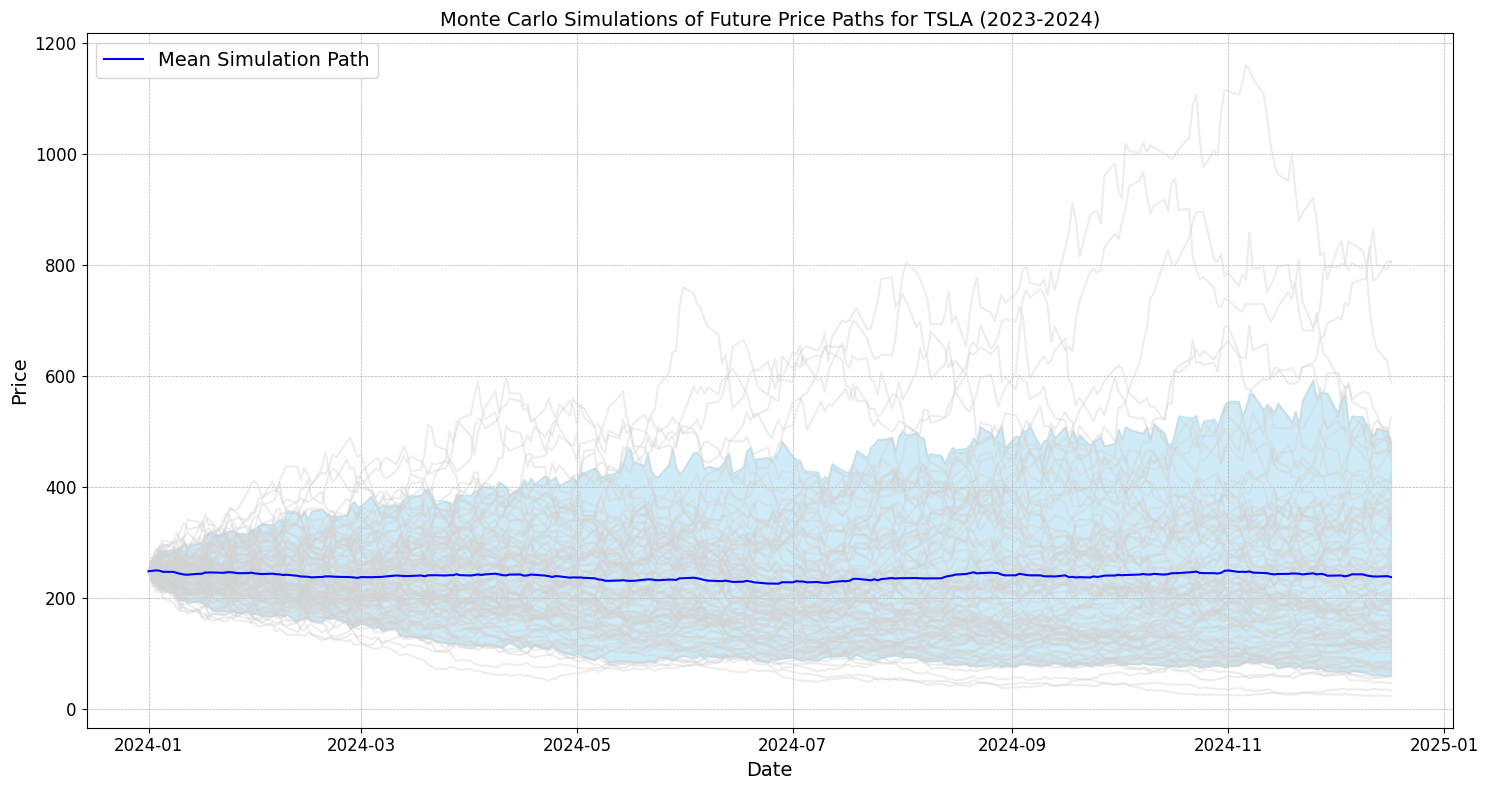

In [17]:
plt.figure(figsize=(15, 8))
plt.plot(forecast_dates, simulated_prices, color='lightgray', alpha=0.4)
plt.plot(forecast_dates, mean_simulated, color='blue', label='Mean Simulation Path')
plt.fill_between(forecast_dates, percentile_5, percentile_95, color='skyblue', alpha=0.4)
plt.title('Monte Carlo Simulations of Future Price Paths for TSLA (2023-2024)', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

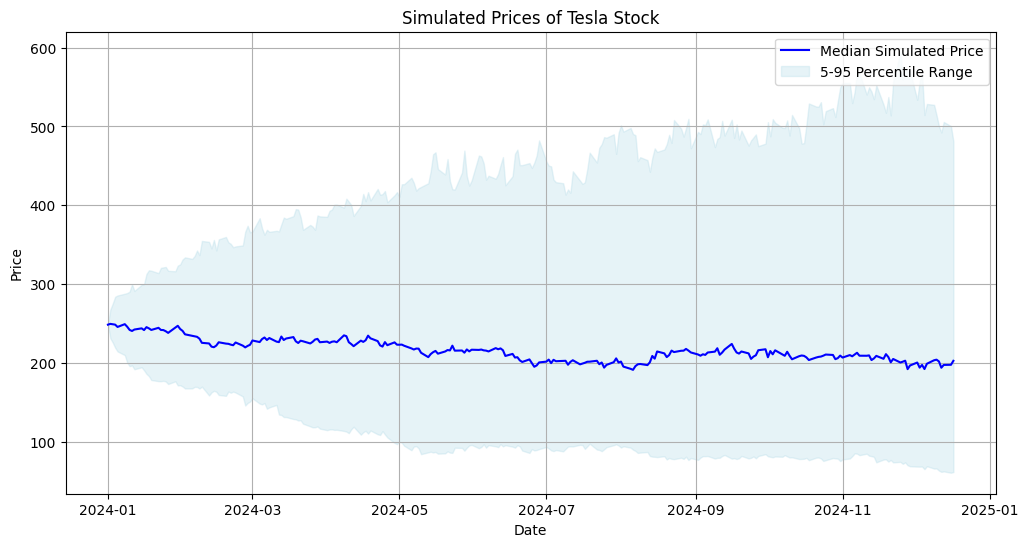

In [18]:
# Calcul des statistiques pour les simulations
median_simulated = np.median(simulated_prices, axis=1)
lower_bound = np.percentile(simulated_prices, 5, axis=1)
upper_bound = np.percentile(simulated_prices, 95, axis=1)

# Tracer la médiane et les intervalles de confiance
plt.figure(figsize=(12, 6))
plt.plot(forecast_dates, median_simulated, color='blue', label='Median Simulated Price')
plt.fill_between(forecast_dates, lower_bound, upper_bound, color='lightblue', alpha=0.3, label='5-95 Percentile Range')
plt.title('Simulated Prices of Tesla Stock')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Calcul des rendements potentiels
simulated_returns = np.diff(simulated_prices, axis=0) / simulated_prices[:-1] * 100


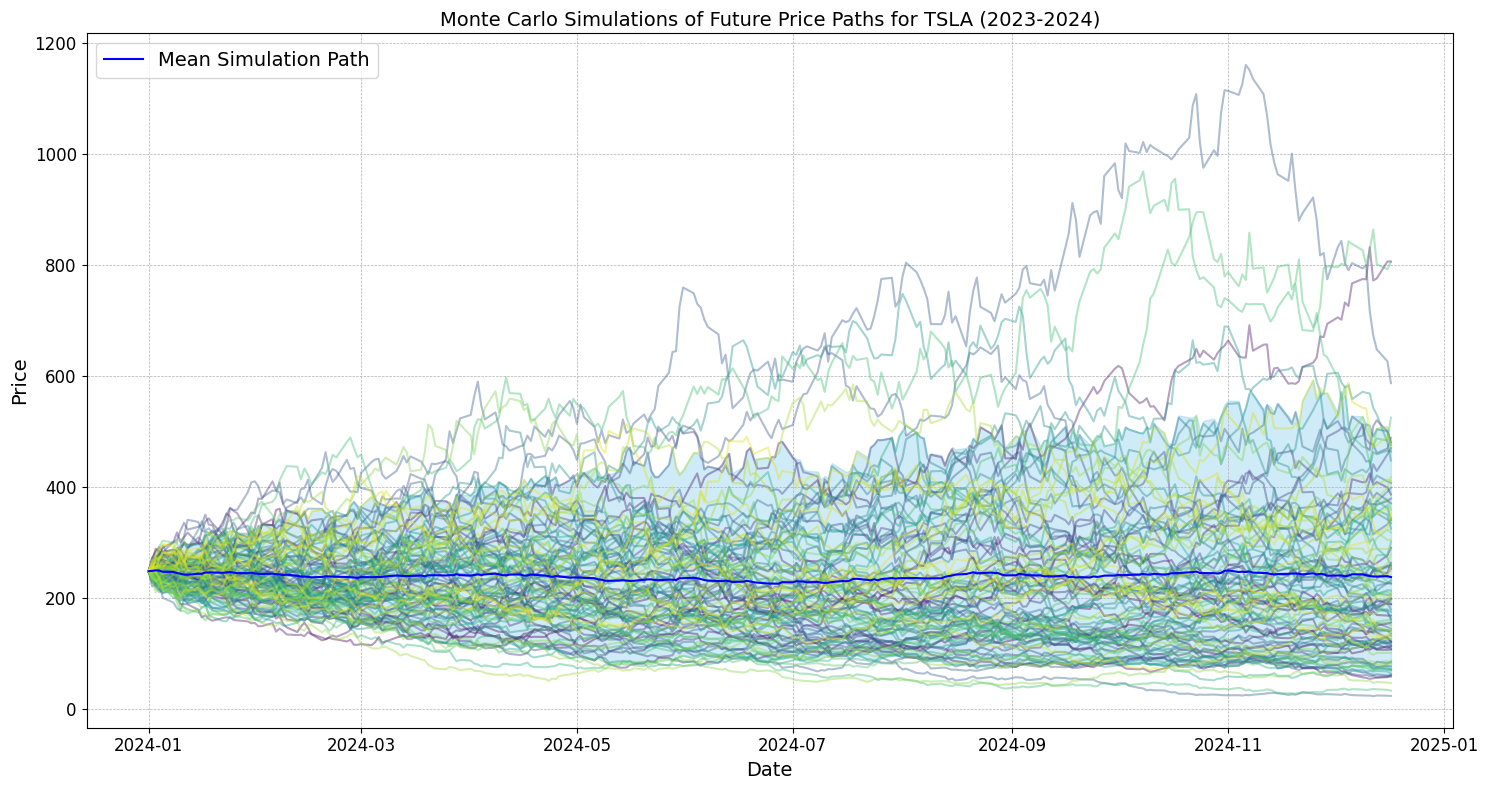

In [20]:
plt.figure(figsize=(15, 8))

# Tracer chaque simulation avec une couleur différente
for i in range(num_simulations):
    plt.plot(forecast_dates, simulated_prices[:, i], color=plt.cm.viridis(i / num_simulations), alpha=0.4)

# Tracer la trajectoire moyenne
plt.plot(forecast_dates, mean_simulated, color='blue', label='Mean Simulation Path')

# Remplir la zone entre les percentiles 5 et 95
plt.fill_between(forecast_dates, percentile_5, percentile_95, color='skyblue', alpha=0.4)

# Définir le titre et les étiquettes des axes
plt.title('Monte Carlo Simulations of Future Price Paths for TSLA (2023-2024)', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Activer la grille
plt.grid(True, which='major', linestyle='--', linewidth=0.5)

# Ajouter une légende
plt.legend(fontsize=14)

# Ajuster la disposition de la figure
plt.tight_layout()

# Afficher le graphique
plt.show()

In [21]:
# Trouver le rendement potentiel le plus élevé pour chaque période de temps
max_returns = np.max(simulated_returns, axis=1)

# Trouver l'index du rendement potentiel le plus élevé pour chaque période de temps
max_returns_index = np.argmax(simulated_returns, axis=1)

# Déterminer les dates correspondant aux rendements potentiels les plus élevés
dates_max_returns = forecast_dates[max_returns_index]

In [29]:
# Specifying the sample
ticker = 'TSLA'
start = '2024-01-01'
end = '2024-02-04'

In [30]:
# Downloading data
prices = yf.download(ticker, start, end)['Close']
# Calculating returns
returns = np.array(prices)[1:] / np.array(prices)[:-1] - 1

[*********************100%***********************]  1 of 1 completed


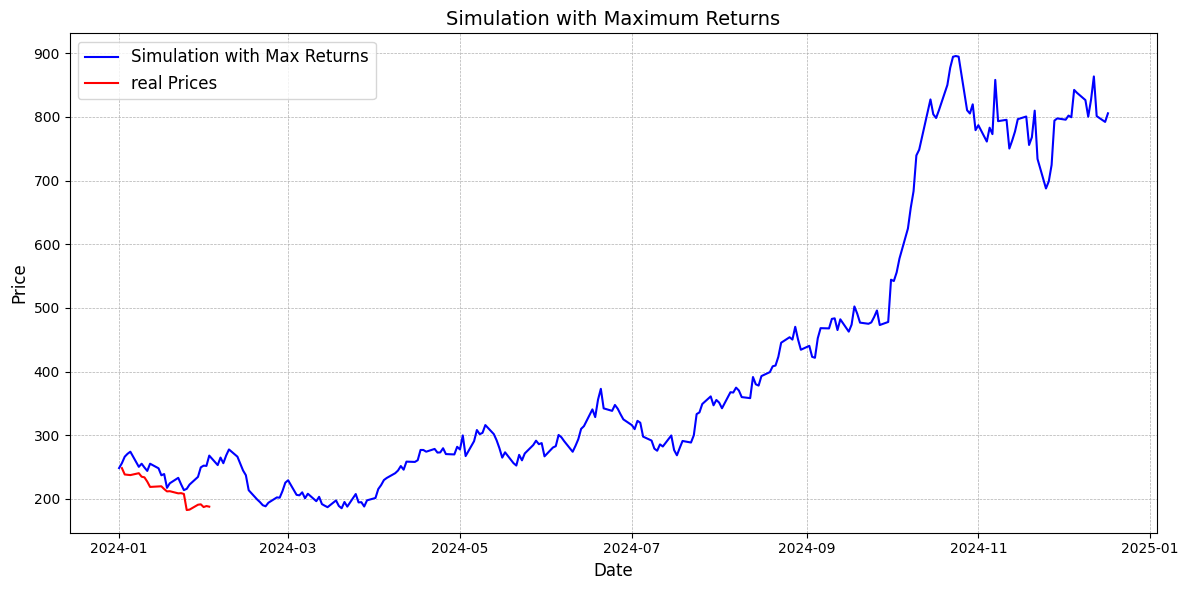

In [31]:
# Calculer les rendements pour chaque simulation
returns_per_simulation = np.diff(simulated_prices, axis=0) / simulated_prices[:-1] * 100

# Trouver l'index de la simulation avec le rendement potentiel le plus élevé
index_max_return = np.argmax(np.sum(returns_per_simulation, axis=0))

# Extraire la simulation correspondante
simulation_max_return = simulated_prices[:, index_max_return]

# Tracer la simulation
plt.figure(figsize=(12, 6))
plt.plot(forecast_dates, simulation_max_return, color='blue', label='Simulation with Max Returns')
plt.plot(prices, color='red', label='real Prices')
plt.title('Simulation with Maximum Returns', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Essayer de trouver pourquoi en octobre l'action à subit un bon

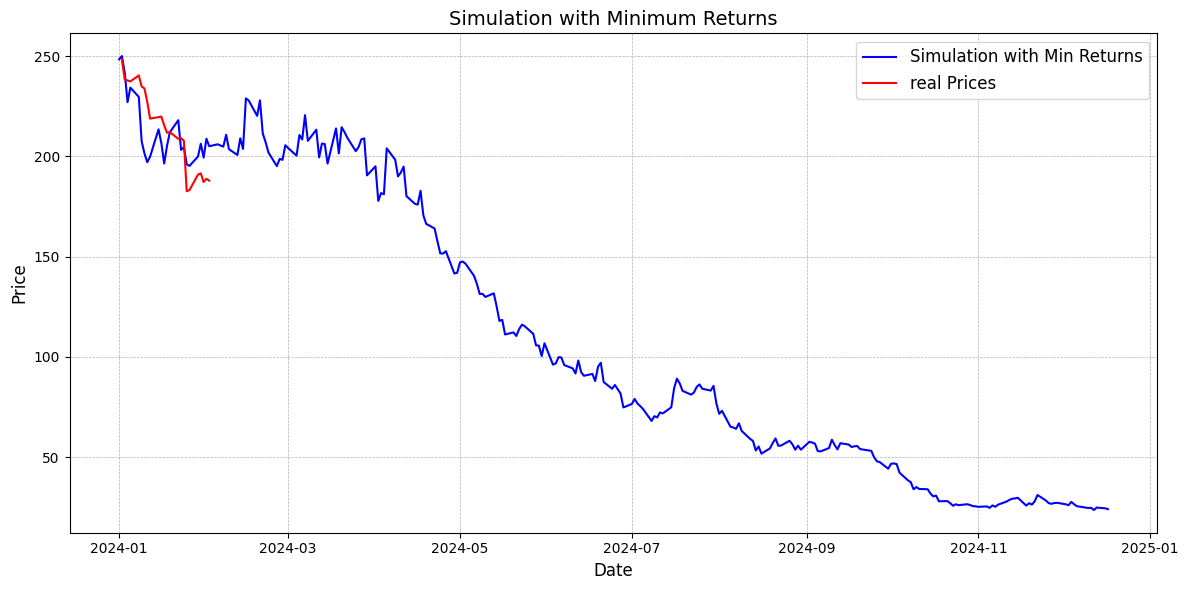

In [32]:
# Trouver l'index de la simulation avec le rendement potentiel le plus élevé
index_min_return = np.argmin(np.sum(returns_per_simulation, axis=0))

# Extraire la simulation correspondante
simulation_max_return = simulated_prices[:, index_min_return]

# Tracer la simulation
plt.figure(figsize=(12, 6))
plt.plot(forecast_dates, simulation_max_return, color='blue', label='Simulation with Min Returns')
plt.plot(prices, color='red', label='real Prices')
plt.title('Simulation with Minimum Returns', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [24]:
# Extraire les rendements correspondant aux simulations avec le rendement le plus haut et le plus bas
returns_max = returns_per_simulation[:, index_max_return]
returns_min = returns_per_simulation[:, index_min_return]

In [25]:
# Créer des DataFrames pandas pour les rendements avec les dates correspondantes
df_returns_max = pd.DataFrame({'Date': forecast_dates[1:], 'Returns': returns_max})
df_returns_min = pd.DataFrame({'Date': forecast_dates[1:], 'Returns': returns_min})
df_returns_max

,Date,Returns
0,2024-01-02,3.126367
1,2024-01-03,3.948676
2,2024-01-04,1.711125
3,2024-01-05,1.202544
4,2024-01-08,-8.646425
...,...,...
246,2024-12-11,3.333732
247,2024-12-12,4.414413
248,2024-12-13,-7.216253
249,2024-12-16,-1.138161


In [26]:
from statsmodels.tsa.api import SARIMAX
from scipy.stats import norm

In [27]:
residual = returns - mu

In [28]:
# Calculer les densités de probabilité conditionnelles
probabilities = norm.pdf(residual)

# Normaliser les densités de probabilité
probabilities_normalized = probabilities / np.sum(probabilities, axis=0)

# Calculer les probabilités de réalisation pour chaque simulation à chaque période de temps
probabilities_realization = np.prod(probabilities_normalized, axis=0)

# Afficher les probabilités de réalisation pour chaque simulation
print(probabilities_realization)

0.0
